# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_119  A0A0A6YYJ2;P42857;P42857-2   16.036
Sample_207  Q96IU4                       15.534
Sample_204  P01814                       16.235
Sample_101  P30086                       19.552
Sample_004  P52799                       16.690
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups      
Sample_133  Q9H6B4                 16.168
Sample_025  Q9ULZ9                 13.312
Sample_004  A8MXB9;J3KQJ1;Q8NBJ7   14.388
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.764
            A0A075B6Q5                 13.212
            A0A075B6R2                 12.838
            A0A075B6S5                 11.084
            A0A087WSY4                 13.285
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.309
            Q9UI40;Q9UI40-2            12.271
            Q9UIW2                     13.741
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.788
            Q9UP79                     12.576
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.177,15.050,16.842,19.863,16.030,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.662,19.067,...,15.528,15.576,14.357,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.031,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.014,17.705,17.039,16.198,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.124,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.367,15.345,17.084,18.708,14.249,19.433,11.267,11.188
Sample_207,15.739,16.877,15.469,16.898,14.268,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.764,...,16.012,15.178,13.691,15.050,16.842,19.863,14.132,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.232,19.067,16.188,...,15.528,15.576,12.956,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.675,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.000,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.291,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.125,15.345,17.084,18.708,14.249,19.433,11.855,11.414
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 396.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]

100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.54it/s]

100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.43it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.33it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.39it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.87it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.52it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.20it/s]

100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.15it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.24it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.55it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.34it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.14it/s]

100%|██████████| 7/7 [00:02<00:00,  2.17it/s]

100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.58it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.96it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.26it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  1.93it/s]

100%|██████████| 8/8 [00:03<00:00,  1.90it/s]

100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.70it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.66it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.20it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.01it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.81it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.84it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.87it/s]

100%|██████████| 9/9 [00:04<00:00,  1.97it/s]

100%|██████████| 9/9 [00:04<00:00,  2.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.41it/s]

 30%|███       | 3/10 [00:00<00:01,  3.59it/s]

 40%|████      | 4/10 [00:01<00:01,  3.22it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.71it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.42it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.18it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.21it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.27it/s]

100%|██████████| 10/10 [00:03<00:00,  2.37it/s]

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.87it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.30it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.64it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.90it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.42it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.09it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.86it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.85it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.82it/s]

100%|██████████| 11/11 [00:04<00:00,  1.89it/s]

100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.41it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.27it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.70it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.34it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.05it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.87it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.84it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.81it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.89it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.00it/s]

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.53it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.74it/s]

 31%|███       | 4/13 [00:01<00:03,  2.34it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.34it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.41it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.19it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.98it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.86it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.96it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.94it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.10it/s]

100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

100%|██████████| 13/13 [00:05<00:00,  2.21it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.46it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.43it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.88it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.58it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.46it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.33it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.35it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.12it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.02it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.06it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.27it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.39it/s]

100%|██████████| 14/14 [00:05<00:00,  2.50it/s]

100%|██████████| 14/14 [00:05<00:00,  2.44it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.08it/s]

 20%|██        | 3/15 [00:00<00:03,  3.30it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.05it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.97it/s]

 40%|████      | 6/15 [00:01<00:03,  2.95it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.40it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.11it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.06it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.11it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.17it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.33it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.50it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.52it/s]

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

100%|██████████| 15/15 [00:05<00:00,  2.53it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.085 0.034          0.706 0.393       0.109   
2             0.005 0.004      0.068 0.020          0.661 0.100       0.563   
3             0.004 0.003      0.062 0.026          0.747 0.093       0.697   
4             0.006 0.006      0.074 0.031          0.728 0.093       0.713   
5             0.007 0.006      0.080 0.028          0.783 0.086       0.747   
6             0.007 0.006      0.073 0.028          0.784 0.097       0.748   
7             0.005 0.004      0.080 0.034          0.790 0.102       0.747   
8             0.007 0.006      0.076 0.032          0.801 0.080       0.820   
9             0.008 0.007      0.090 0.037          0.806 0.081       0.805   
10            0.008 0.009      0.086 0.031          0.803 0.083       0.805   
11            0.006 0.004      0.075 0.028          0.796 0.083       0.804   
12            0.007 0.006      0.069 0.030          0.791 0.081       0.803   
13            0.006 0.005      0.078 0.039          0.789 0.089       0.803   
14            0.008 0.007      0.093 0.046          0.790 0.090       0.803   
15            0.008 0.008      0.091 0.035          0.787 0.089       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.181 0.134                  0.547 0.042        0.855   
2          0.106   0.601 0.082                  0.673 0.060        0.730   
3          0.107   0.715 0.080                  0.759 0.065        0.843   
4          0.109   0.715 0.084                  0.757 0.069        0.841   
5          0.129   0.756 0.085                  0.795 0.067        0.846   
6          0.107   0.760 0.082                  0.796 0.068        0.864   
7          0.110   0.762 0.085                  0.799 0.070        0.872   
8          0.098   0.806 0.069                  0.834 0.059        0.903   
9          0.103   0.801 0.071                  0.830 0.060        0.900   
10         0.103   0.800 0.072                  0.829 0.061        0.900   
11         0.105   0.796 0.073                  0.825 0.062        0.899   
12         0.106   0.793 0.075                  0.823 0.064        0.899   
13         0.100   0.791 0.075                  0.821 0.063        0.904   
14         0.104   0.791 0.075                  0.821 0.064        0.901   
15         0.099   0.787 0.073                  0.817 0.062        0.900   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.829 0.087        210.000 0.000  
2          0.073                  0.663 0.089        210.000 0.000  
3          0.070                  0.810 0.092        210.000 0.000  
4          0.069                  0.809 0.088        210.000 0.000  
5          0.066                  0.810 0.085        210.000 0.000  
6          0.064                  0.853 0.072        210.000 0.000  
7          0.062                  0.862 0.069        210.000 0.000  
8          0.050                  0.892 0.050        210.000 0.000  
9          0.051                  0.887 0.053        210.000 0.000  
10         0.051                  0.887 0.053        210.000 0.000  
11         0.051                  0.886 0.054        210.000 0.000  
12         0.051                  0.885 0.054        210.000 0.000  
13         0.051                  0.895 0.051        210.000 0.000  
14         0.051                  0.892 0.052        210.000 0.000  
15         0.050                  0.891 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 464.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.19it/s]

100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.85it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.52it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.24it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.36it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.28it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.44it/s]

100%|██████████| 6/6 [00:02<00:00,  1.94it/s]

100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.79it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.54it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.24it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.54it/s]

100%|██████████| 7/7 [00:02<00:00,  2.33it/s]

100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.77it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.18it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.86it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.33it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  1.92it/s]

100%|██████████| 8/8 [00:03<00:00,  1.79it/s]

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.42it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.14it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.88it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.77it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.80it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.15it/s]

100%|██████████| 9/9 [00:03<00:00,  2.01it/s]

100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.63it/s]

 30%|███       | 3/10 [00:00<00:02,  3.27it/s]

 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.77it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.47it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.14it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.92it/s]

100%|██████████| 10/10 [00:04<00:00,  1.78it/s]

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.63it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.47it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.05it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.76it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.74it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.36it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.09it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.93it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.87it/s]

100%|██████████| 11/11 [00:04<00:00,  2.01it/s]

100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.25it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.08it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.64it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.12it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.75it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.71it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.70it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.81it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.93it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.97it/s]

100%|██████████| 12/12 [00:05<00:00,  2.07it/s]

100%|██████████| 12/12 [00:05<00:00,  2.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.43it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.27it/s]

 31%|███       | 4/13 [00:01<00:03,  2.42it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.10it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.86it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.81it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.76it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.83it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.06it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.20it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.29it/s]

100%|██████████| 13/13 [00:06<00:00,  2.24it/s]

100%|██████████| 13/13 [00:06<00:00,  2.17it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.95it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.81it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.63it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.11it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.97it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.93it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.91it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.04it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.14it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.22it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.30it/s]

100%|██████████| 14/14 [00:06<00:00,  2.15it/s]

100%|██████████| 14/14 [00:06<00:00,  2.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.06it/s]

 20%|██        | 3/15 [00:00<00:03,  3.13it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.77it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.71it/s]

 40%|████      | 6/15 [00:02<00:03,  2.50it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.05it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.05it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.93it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.00it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.07it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.25it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.28it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.17it/s]

100%|██████████| 15/15 [00:06<00:00,  2.09it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.078 0.041          0.010 0.071       0.001   
2             0.007 0.007      0.093 0.047          0.202 0.377       0.021   
3             0.009 0.008      0.106 0.045          0.776 0.087       0.703   
4             0.007 0.006      0.083 0.039          0.784 0.091       0.714   
5             0.009 0.007      0.097 0.043          0.779 0.093       0.725   
6             0.009 0.008      0.102 0.039          0.788 0.097       0.738   
7             0.007 0.007      0.096 0.043          0.791 0.100       0.744   
8             0.006 0.005      0.080 0.034          0.784 0.101       0.732   
9             0.007 0.005      0.084 0.035          0.769 0.096       0.769   
10            0.006 0.005      0.076 0.028          0.782 0.094       0.765   
11            0.008 0.007      0.082 0.034          0.788 0.094       0.786   
12            0.007 0.006      0.076 0.035          0.792 0.092       0.780   
13            0.008 0.006      0.084 0.038          0.795 0.091       0.781   
14            0.007 0.005      0.075 0.027          0.788 0.091       0.782   
15            0.005 0.004      0.062 0.021          0.797 0.090       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.860   
2          0.042   0.037 0.072                  0.505 0.019        0.814   
3          0.099   0.732 0.068                  0.775 0.054        0.888   
4          0.105   0.742 0.078                  0.783 0.062        0.892   
5          0.101   0.746 0.073                  0.785 0.060        0.891   
6          0.114   0.756 0.084                  0.794 0.069        0.895   
7          0.115   0.761 0.087                  0.798 0.072        0.894   
8          0.110   0.751 0.084                  0.790 0.070        0.894   
9          0.114   0.763 0.081                  0.798 0.069        0.906   
10         0.119   0.768 0.086                  0.803 0.072        0.908   
11         0.113   0.781 0.083                  0.813 0.071        0.914   
12         0.112   0.781 0.083                  0.813 0.071        0.915   
13         0.112   0.783 0.081                  0.815 0.070        0.914   
14         0.112   0.780 0.082                  0.813 0.071        0.913   
15         0.110   0.795 0.074                  0.825 0.064        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.828 0.087        210.000 0.000  
2          0.109                  0.777 0.123        210.000 0.000  
3          0.050                  0.857 0.059        210.000 0.000  
4          0.050                  0.861 0.061        210.000 0.000  
5          0.051                  0.860 0.062        210.000 0.000  
6          0.051                  0.865 0.062        210.000 0.000  
7          0.053                  0.865 0.063        210.000 0.000  
8          0.054                  0.863 0.065        210.000 0.000  
9          0.049                  0.877 0.060        210.000 0.000  
10         0.049                  0.879 0.060        210.000 0.000  
11         0.048                  0.889 0.057        210.000 0.000  
12         0.048                  0.892 0.057        210.000 0.000  
13         0.048                  0.890 0.057        210.000 0.000  
14         0.048                  0.888 0.058        210.000 0.000  
15         0.046                  0.892 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 945.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 14.31it/s]

100%|██████████| 2/2 [00:00<00:00, 14.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.49it/s]

100%|██████████| 3/3 [00:00<00:00, 14.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 14.12it/s]

100%|██████████| 4/4 [00:00<00:00, 10.28it/s]

100%|██████████| 4/4 [00:00<00:00, 10.63it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 16.53it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.01it/s]

100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 12.75it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.29it/s]

100%|██████████| 6/6 [00:00<00:00, 11.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.28it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.61it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 13.88it/s]

100%|██████████| 7/7 [00:00<00:00, 14.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.61it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.30it/s]

100%|██████████| 8/8 [00:00<00:00, 13.75it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.07it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.90it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.23it/s]

100%|██████████| 9/9 [00:00<00:00, 12.68it/s]

100%|██████████| 9/9 [00:00<00:00, 13.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.51it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.29it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.20it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.07it/s]

100%|██████████| 10/10 [00:00<00:00, 14.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.72it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.09it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.46it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.69it/s]

100%|██████████| 11/11 [00:00<00:00, 14.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.31it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.35it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.07it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.95it/s]

100%|██████████| 12/12 [00:00<00:00, 12.39it/s]

100%|██████████| 12/12 [00:00<00:00, 13.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.30it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.12it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.93it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.37it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.03it/s]

100%|██████████| 13/13 [00:01<00:00, 12.37it/s]

100%|██████████| 13/13 [00:01<00:00, 12.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.39it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.83it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.83it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.55it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.20it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.16it/s]

100%|██████████| 14/14 [00:01<00:00, 12.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.12it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.45it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.82it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.19it/s]

 73%|███████▎  | 11/15 [00:00<00:00,  9.88it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.26it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.02it/s]

100%|██████████| 15/15 [00:01<00:00,  9.11it/s]

100%|██████████| 15/15 [00:01<00:00, 10.27it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.072 0.028          0.000 0.000       0.000   
2             0.006 0.007      0.060 0.020          0.563 0.113       0.376   
3             0.006 0.005      0.067 0.028          0.668 0.091       0.557   
4             0.005 0.003      0.062 0.022          0.664 0.099       0.552   
5             0.004 0.002      0.050 0.008          0.661 0.112       0.581   
6             0.004 0.002      0.051 0.016          0.690 0.093       0.651   
7             0.004 0.002      0.053 0.015          0.691 0.091       0.653   
8             0.005 0.003      0.052 0.015          0.694 0.094       0.643   
9             0.005 0.003      0.053 0.014          0.691 0.096       0.638   
10            0.004 0.002      0.049 0.014          0.679 0.103       0.606   
11            0.004 0.002      0.052 0.013          0.679 0.104       0.607   
12            0.004 0.002      0.050 0.009          0.673 0.104       0.601   
13            0.005 0.002      0.051 0.013          0.678 0.100       0.620   
14            0.005 0.002      0.053 0.013          0.670 0.094       0.613   
15            0.007 0.004      0.071 0.023          0.679 0.096       0.624   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.739   
2          0.091   0.443 0.084                  0.577 0.061        0.645   
3          0.098   0.602 0.078                  0.676 0.058        0.763   
4          0.099   0.596 0.080                  0.671 0.059        0.763   
5          0.110   0.612 0.089                  0.678 0.070        0.780   
6          0.117   0.663 0.082                  0.715 0.066        0.798   
7          0.107   0.665 0.076                  0.717 0.062        0.796   
8          0.118   0.661 0.086                  0.716 0.067        0.796   
9          0.123   0.657 0.090                  0.713 0.070        0.793   
10         0.118   0.634 0.093                  0.697 0.071        0.795   
11         0.116   0.635 0.092                  0.697 0.071        0.792   
12         0.118   0.628 0.092                  0.691 0.071        0.792   
13         0.107   0.642 0.086                  0.700 0.069        0.790   
14         0.112   0.633 0.083                  0.693 0.065        0.784   
15         0.110   0.643 0.081                  0.700 0.064        0.788   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.682 0.086        210.000 0.000  
2          0.084                  0.609 0.092        210.000 0.000  
3          0.066                  0.708 0.082        210.000 0.000  
4          0.066                  0.723 0.077        210.000 0.000  
5          0.067                  0.735 0.079        210.000 0.000  
6          0.066                  0.750 0.079        210.000 0.000  
7          0.068                  0.750 0.079        210.000 0.000  
8          0.066                  0.748 0.078        210.000 0.000  
9          0.068                  0.746 0.077        210.000 0.000  
10         0.065                  0.744 0.079        210.000 0.000  
11         0.065                  0.741 0.078        210.000 0.000  
12         0.063                  0.741 0.078        210.000 0.000  
13         0.064                  0.739 0.080        210.000 0.000  
14         0.066                  0.732 0.083        210.000 0.000  
15         0.063                  0.738 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,5,15
score_time,14,3,1
test_precision,9,15,8
test_recall,8,15,7
test_f1,8,15,7
test_balanced_accuracy,8,15,7
test_roc_auc,13,15,6
test_average_precision,13,15,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.54it/s]

 20%|██        | 3/15 [00:00<00:03,  3.04it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.46it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.12it/s]

 40%|████      | 6/15 [00:02<00:04,  1.92it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.79it/s]

 53%|█████▎    | 8/15 [00:03<00:04,  1.72it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.78it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.85it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.91it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.00it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.97it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.00it/s]

100%|██████████| 15/15 [00:07<00:00,  2.14it/s]

100%|██████████| 15/15 [00:07<00:00,  2.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 15.56it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.07it/s]

100%|██████████| 6/6 [00:00<00:00, 11.87it/s]

100%|██████████| 6/6 [00:00<00:00, 11.82it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.15it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.06it/s]

 31%|███       | 4/13 [00:01<00:02,  3.72it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.09it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.96it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.96it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.01it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.97it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.54it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.35it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.17it/s]

100%|██████████| 13/13 [00:04<00:00,  2.27it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


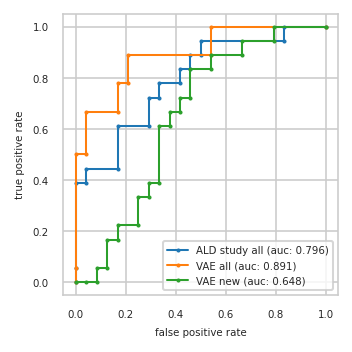

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.500   0.083 0.000
3          0.042 0.389   0.042 0.500   0.083 0.056
4          0.042 0.444   0.042 0.667   0.125 0.056
5          0.167 0.444   0.167 0.667   0.125 0.167
6          0.167 0.611   0.167 0.778   0.167 0.167
7          0.292 0.611   0.208 0.778   0.167 0.222
8          0.292 0.722   0.208 0.889   0.250 0.222
9          0.333 0.722   0.542 0.889   0.250 0.333
10         0.333 0.778   0.542 1.000   0.292 0.333
11         0.417 0.778   1.000 1.000   0.292 0.389
12         0.417 0.833     NaN   NaN   0.333 0.389
13         0.458 0.833     NaN   NaN   0.333 0.611
14         0.458 0.889     NaN   NaN   0.375 0.611
15         0.500 0.889     NaN   NaN   0.375 0.667
16         0.500 0.944     NaN   NaN   0.417 0.667
17         0.833 0.944     NaN   NaN   0.417 0.722
18         0.833 1.000     NaN   NaN   0.458 0.722
19         1.000 1.000     NaN   NaN   0.458 0.833
20           NaN   NaN     NaN   NaN   0.542 0.833
21           NaN   NaN     NaN   NaN   0.542 0.889
22           NaN   NaN     NaN   NaN   0.667 0.889
23           NaN   NaN     NaN   NaN   0.667 0.944
24           NaN   NaN     NaN   NaN   0.792 0.944
25           NaN   NaN     NaN   NaN   0.792 1.000
26           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q14165,A0A0J9YXX1,P51688
2,P08670,A6NNI4;G8JLH6;P21926,P36269;P36269-2;P36269-3
3,B0QYF8;P02144,Q9Y2T3;Q9Y2T3-3,P31321
4,P04075,P61981,A0A075B7B8
5,P61981,P14174,E9PK25;G3V1A4;P23528
6,P01597;P04432,P04075,None
7,P14174,Q14894,None
8,A0A0C4DGY8;D6RA00;Q9UHY7,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


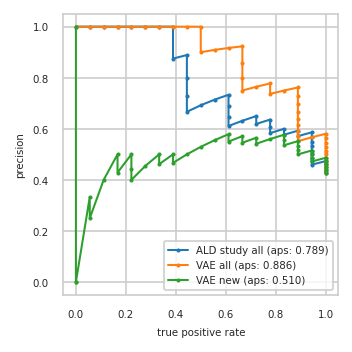

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.552 0.889     0.552 0.889
14         0.571 0.889     0.571 0.889     0.536 0.833
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.577 0.833     0.615 0.889     0.577 0.833
17         0.600 0.833     0.640 0.889     0.560 0.778
18         0.583 0.778     0.667 0.889     0.542 0.722
19         0.609 0.778     0.696 0.889     0.565 0.722
20         0.636 0.778     0.727 0.889     0.545 0.667
21         0.619 0.722     0.762 0.889     0.571 0.667
22         0.650 0.722     0.750 0.833     0.550 0.611
23         0.632 0.667     0.737 0.778     0.579 0.611
24         0.611 0.611     0.778 0.778     0.556 0.556
25         0.647 0.611     0.765 0.722     0.529 0.500
26         0.688 0.611     0.750 0.667     0.500 0.444
27         0.733 0.611     0.800 0.667     0.467 0.389
28         0.714 0.556     0.857 0.667     0.500 0.389
29         0.692 0.500     0.923 0.667     0.462 0.333
30         0.667 0.444     0.917 0.611     0.500 0.333
31         0.727 0.444     0.909 0.556     0.455 0.278
32         0.800 0.444     0.900 0.500     0.400 0.222
33         0.889 0.444     1.000 0.500     0.444 0.222
34         0.875 0.389     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


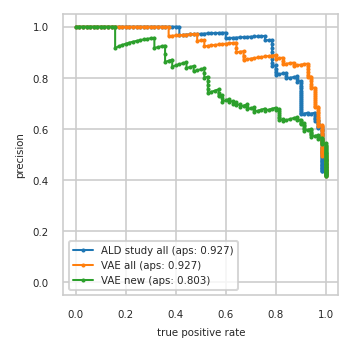

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


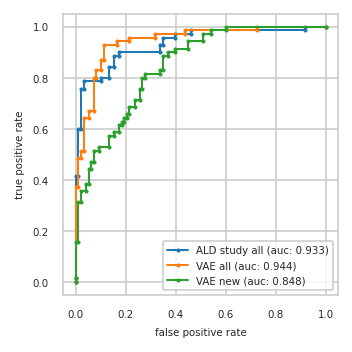

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}